# DataFrame内のあるフィールドに設定された要素の種類ごとにレコードを抽出し、行と列を入れ替えて新しいDataFrameを生成する。

1. CSV読み込み。`.read_csv`
1. 日時のデータが入っているフィールドをDateTime型に変換。`.to_datetime`
1. DateTimeのフォーマットを変更。`dt.strftime('%m-%d')`
1. あるフィールドの要素ごとに、データ抽出。`.groupby`、`for idx, df_select in df_grp.groupby(level=[0]):`
1. 行列を入れ替えて新しくDataFrameを生成。
1. テスト

---
## 1. CSVファイル読み込み DataFrameに保存

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_encoding = 'Shift_JISx0213'
inputFile = ".\\Data\\01_DateTimeData.csv"
df = pd.read_csv(inputFile,index_col=False, encoding=csv_encoding)
df = df[['ImpDate','ProNum','STC']]
display(df.head(10))
df.dtypes

,ImpDate,ProNum,STC
0,2019/5/6,1,1
1,2019/5/8,4,2
2,2019/5/8,4,3
3,2019/5/7,2,4
4,2019/5/7,2,5
5,2019/5/8,4,6
6,2019/5/8,4,7
7,2019/5/7,2,8
8,2019/5/7,2,9
9,2019/5/8,4,10


ImpDate    object
ProNum      int64
STC         int64
dtype: object

---
## 2. DataFrame内の値を調整
###  2-1. ImpDateは最終的にIndexとしソートする。ソートを行うためdatetime型に変換する。

In [2]:
df['ImpDate'] = pd.to_datetime(df['ImpDate'])
display(df.head(5))

,ImpDate,ProNum,STC
0,2019-05-06,1,1
1,2019-05-08,4,2
2,2019-05-08,4,3
3,2019-05-07,2,4
4,2019-05-07,2,5


### 2-2. 積み上げ棒グラフのX軸のラベルにするため、datetimeのフォーマットを変換。

In [3]:
df['ImpDate'] = df['ImpDate'].dt.strftime('%m-%d')
display(df.head(5))

,ImpDate,ProNum,STC
0,05-06,1,1
1,05-08,4,2
2,05-08,4,3
3,05-07,2,4
4,05-07,2,5


---
## 3. ImpDate、ProNumでグルーピングし、イテレートしながらグラフ生成用のデータを作る。

  - 縦にImpDate、横にProNumの1～5(Pro1-1～Pro3と名前を変える）データが並んだ、下のようなDataFrameを作りたい。
~~~
index   Pro1-1   Pro1-2    Pro1-3   Pro2   Pro3
04-23   347        1         144     83     0
04-24   204        1           0      0     0
04-25   333        3          51     73   166
04-26   501        3           0     16    58
04-27   394        5           8     12    87
~~~

### 3-1.  列データを作るため、ProNumとImpDateでグルーピング

In [9]:
df_grp = df.groupby(['ProNum', 'ImpDate']).count()
display(df_grp.head(20))

STC
ProNum ImpDate       
1      04-23      347
       04-24      204
       04-25      333
       04-26      501
       04-27      394
       04-28       17
       04-29      375
       04-30      490
       05-01      519
       05-02    44933
       05-03     6834
       05-04     7202
       05-06    19441
       05-08      302
       05-11     2587
       05-16     1227
       05-18      667
       05-21       19
2      04-23        1
       04-24        1

### 3-2. ProNumでループしながら列データを生成し、concatを使って横方向に連結していく。

In [5]:
df_adjusted = pd.DataFrame()

for idx, df_select in df_grp.groupby(level=[0]):
    #print('------------')
    #display(idx)
    #display(df_select.head(5))
    df_tmp = df_select.reset_index().drop('ProNum', axis = 1).set_index('ImpDate')
    #display(df_tmp.head(5))
    df_tmp = df_tmp.rename(columns =  {'STC': idx})
    #display(df_tmp.head(5))
    
    df_adjusted = pd.concat([df_adjusted, df_tmp], axis=1,  sort=True)
    
display(df_adjusted.head(5))

,1,2,3,4,5
04-23,347.0,1.0,144.0,83.0,NaN
04-24,204.0,1.0,NaN,NaN,NaN
04-25,333.0,3.0,51.0,73.0,166.0
04-26,501.0,3.0,NaN,16.0,58.0
04-27,394.0,5.0,8.0,12.0,87.0


### 3-3. NaNを0に置き換え、全体をINTにする。

In [10]:
df_adjusted = df_adjusted.fillna(0).astype(int)
display(df_adjusted.head(10))

,1,2,3,4,5
04-23,347,1,144,83,0
04-24,204,1,0,0,0
04-25,333,3,51,73,166
04-26,501,3,0,16,58
04-27,394,5,8,12,87
04-28,17,5,57,48,198
04-29,375,2,96,0,0
04-30,490,3,0,5,121
05-01,519,13132,39,113,7457
05-02,44933,5486,118,93128,1604


### 3-4. ヘッダ名を変更する。

In [7]:
headers = {1 : "Pro1-1", 2 : "Pro1-2", 3 : "Pro1-3", 4 : "Pro2", 5 : "Pro3"}
df_renamed = df_adjusted.rename(columns = headers)
display(df_renamed.head(5))

,Pro1-1,Pro1-2,Pro1-3,Pro2,Pro3
04-23,347,1,144,83,0
04-24,204,1,0,0,0
04-25,333,3,51,73,166
04-26,501,3,0,16,58
04-27,394,5,8,12,87


---
## 4. 積み上げ棒グラフにする

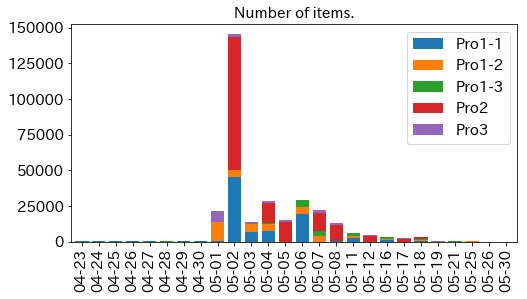

In [8]:
import matplotlib.pyplot as plot

params = {
    'axes.titlesize': 15,
    'axes.labelsize': -1,
    'legend.fontsize': 15,
    'figure.figsize': (8, 4),
    'xtick.labelsize' : 15,
    'ytick.labelsize' : 15
    
}

plot.rcParams.update(params)

df_renamed.plot(kind='bar', stacked=True, width=0.8,  title = "Number of items.")